# Parametric working memory 
Code for exercise 3

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch_directml
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture 
import dataset.generate_dataset as generate_dataset
import models.neural_networks as neural_networks 
import models.latent_dynamics as latent_dynamics
import evaluation.visualise_dynamics as visualise_dynamics
import evaluation.visualise_connectivity as visualise_connectivity
import matplotlib.colors as mcolors
import scipy 

device = torch_directml.device()
print('Using {}'.format(device))

np.random.seed(0)
torch.manual_seed(1)
list_colors = list(mcolors.TABLEAU_COLORS)

Using privateuseone:0


## 1. Generate data.

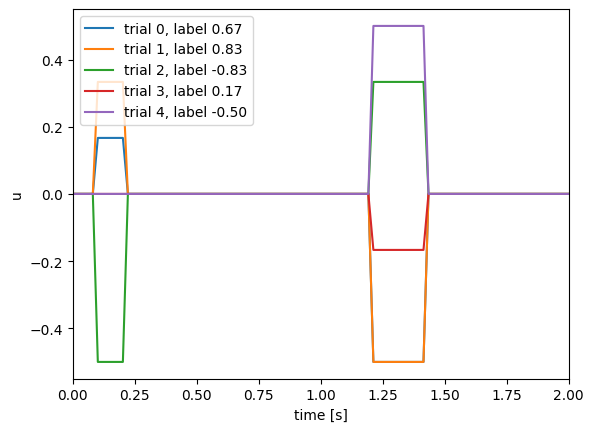

In [2]:
batch_size = 32
num_trials = batch_size * 1000
sampling_rate = 1/(20/1000) #[Hz]
t_onsets = np.array([5, 60]) / sampling_rate # [s]
t_offsets = np.array([10, 70]) / sampling_rate # [s]
t_max = 2000/1000 # [s]
num_trial_to_plot = 5 # should be less than batch_size
stimulus_strength_list  = np.arange(10, 38, 4)

PWM_dataset_train = \
    generate_dataset.PWMStimulus(num_trials, t_onsets, t_offsets, t_max, stimulus_strength_list, sampling_rate)
PWM_dataset_test = \
    generate_dataset.PWMStimulus(int(num_trials/100), t_onsets, t_offsets, t_max, stimulus_strength_list, sampling_rate)

fig = PWM_dataset_train.plot_stimulus(np.arange(num_trial_to_plot))
plt.show()

In [3]:
train_dataloader = \
    DataLoader(PWM_dataset_train, batch_size=batch_size)#, shuffle=True)
test_dataloader = \
    DataLoader(PWM_dataset_test, batch_size=batch_size)#, shuffle=True)

## 2. Low rank RNN  

In [4]:
input_size = 1
hidden_size = 128
output_size = 1
rank = 2
time_step = 20/1000 # s 
tau = 100/1000 # s
model = neural_networks.LowRankRNN(
    input_size, hidden_size, 
    output_size, rank, 
    time_step, tau).to(device)
print(model)

LowRankRNN(
  (feedforward_input): LinearAmpFactor(in_features=1, out_features=128)
  (recurrent_input): RNNLayer(in_features=128, out_features=128)
  (readout): LinearAmpFactor(in_features=128, out_features=1)
)


Run simulation & Visualise a time course of each hidden node.  

try simulation for the first batch
shape of stimulus:  torch.Size([32, 100])
shape of label: torch.Size([32])


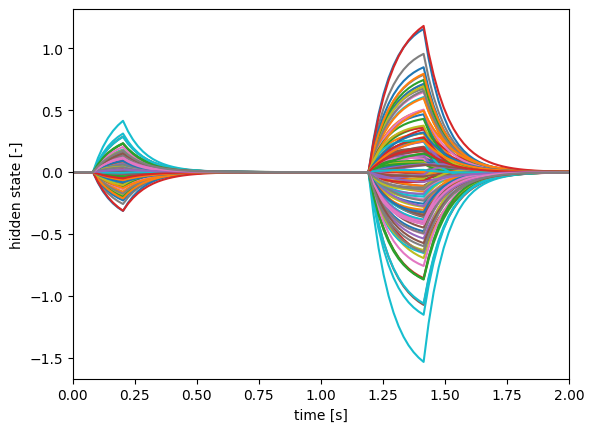

In [5]:
sample_batched = next(iter(train_dataloader))
print('try simulation for the first batch')
print('shape of stimulus: ', sample_batched['stimulus'].size())
print('shape of label:', sample_batched['label'].size())

visualise_dynamics.plot_hidden_nodes_single_trial(
    device, model, t_max, PWM_dataset_train, train_dataloader)

## 3. Train network

In [6]:
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 5e-3
loss_min = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
time_step_for_loss = 5 #[-] not in sec    

In [7]:
def train(dataloader, model, loss_fn, optimizer, time_step_for_loss):
    num_epoches = len(dataloader)
    loss_history = []
    for i_batch, sample_batched in enumerate(dataloader):
        #print(i_batch, sample_batched['stimulus'].size(),
        #      sample_batched['label'].size())      
              
        _batch_size = len(sample_batched['stimulus'])
        hidden_state = model.init_hidden(_batch_size)        
        loss = 0 
        optimizer.zero_grad()
        #print(sample_batched['stimulus'].shape)
        num_sample_points = sample_batched['stimulus'].shape[1]
        
        for i_time in range(num_sample_points):
            #print(sample_batched['stimulus'].shape)
            input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
            label_data = sample_batched['label'].float().to(device)
            hidden_state = hidden_state.to(device)
            output, hidden_state = model(input_data, hidden_state)
            
            if i_time >=(num_sample_points - time_step_for_loss):
                #print(output.shape)
                #print(loss_fn(output.squeeze().to(device), label_data))
                loss += loss_fn(output.squeeze().to(device), label_data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), i_batch * _batch_size
        
        if i_batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{num_epoches*_batch_size:>5d}]")    
            # plot the first 4 trials in the batch                
            #for i_trial in range(4):
            #    plt.plot(sample_batched['stimulus'][i_trial, :], \
            #            label='trial {:d}, label {:.2f}'.format(int(i_trial), sample_batched['label'][i_trial]))
            #plt.xlabel('time sample [-]')
            #plt.ylabel('u')
            #plt.legend()
            #plt.title('Batch {}'.format(i_batch))
            #plt.show()
        
        loss_history.append(loss)

    return loss_history 

def test(dataloader, model, loss_fn, time_step_for_loss):
    num_epoches = len(dataloader)
    model.eval()
    test_loss = 0 
    correct = 0
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(dataloader):
            _batch_size = len(sample_batched['stimulus'])
            hidden_state = model.init_hidden(_batch_size)
            num_sample_points = sample_batched['stimulus'].shape[1]
         
            for i_time in range(num_sample_points):
                input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1).to(device)
                label_data = sample_batched['label'].float().to(device)
                hidden_state = hidden_state.to(device)
                output, hidden_state = model(input_data, hidden_state)   
            if i_time >=(num_sample_points - time_step_for_loss):
                test_loss += loss_fn(output.squeeze().to(device), label_data) 

            correct += ((output.sign() * label_data.sign()) == 1).sum().item() / _batch_size

    test_loss /= num_epoches
    correct /= num_epoches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

/home/yota/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


loss: 1.498138  [   32/32000]
loss: 0.610382  [ 3232/32000]
loss: 0.515167  [ 6432/32000]
loss: 0.516658  [ 9632/32000]
loss: 0.498149  [12832/32000]
loss: 0.612694  [16032/32000]
loss: 0.554568  [19232/32000]
loss: 0.520806  [22432/32000]
loss: 0.469898  [25632/32000]
loss: 0.488162  [28832/32000]


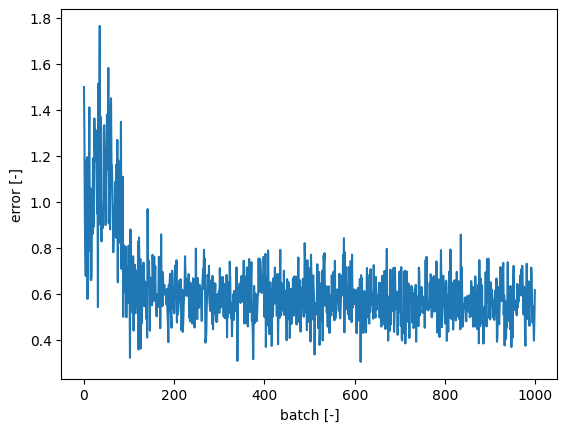

In [8]:
# train model 
loss_history = \
    train(train_dataloader, model, loss_fn, optimizer, time_step_for_loss)

plt.plot(loss_history)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()

Test Error: 
 Accuracy: 64.1%, Avg loss: 0.117070 



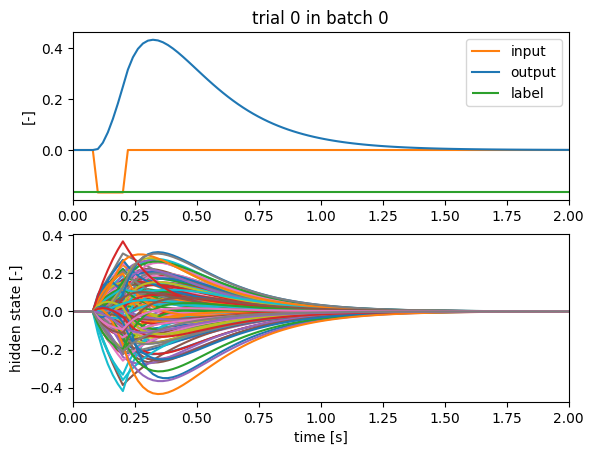

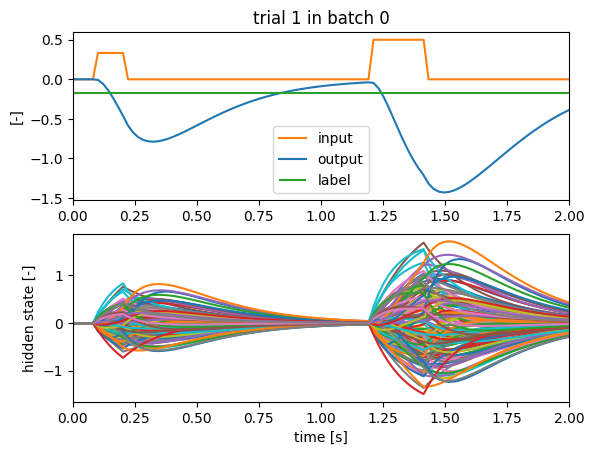

In [9]:
# test model 
test(test_dataloader, model, loss_fn, time_step_for_loss)

# visualise dynamics of trained RNN
visualise_dynamics.plot_dynamics_each_trial(
    device, model, t_max, PWM_dataset_test, 
    test_dataloader, num_trial_to_plot=2)

### Curriculum learning by increasing the inter-stimulus interval. 
Increase the difficulty of the task in a training dataset to obtain better models.

Create a training dataset. 

make sure to set num_trials & t_max large enough
100 torch.Size([32, 100]) torch.Size([32])


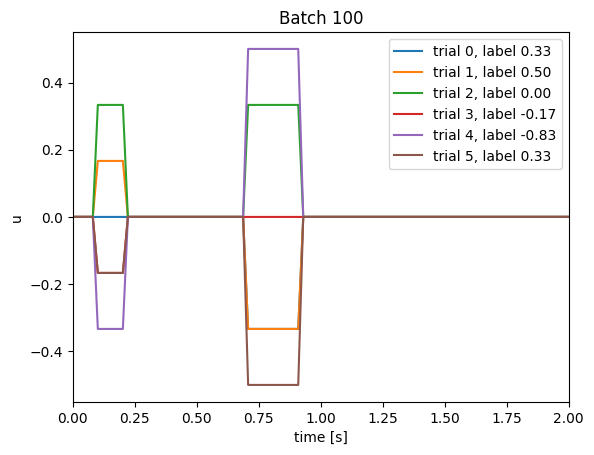

In [26]:
# gradually increase delays between two stimuli [s]
# delay = 0 corresponds to the original stimulus onset/offset
delays = np.array([-25, -10, 0]) / sampling_rate # [s] 
t_max_curriculum_learning = 2000/1000 # [s]

PWM_dataset_train_curriculum_learning = \
    generate_dataset.PWMStimulus(num_trials, 
                                 t_onsets, 
                                 t_offsets, 
                                 t_max_curriculum_learning, 
                                 stimulus_strength_list, 
                                 sampling_rate, 
                                 delays)

train_dataloader_curriculum_learning = \
    DataLoader(PWM_dataset_train_curriculum_learning, 
               batch_size=batch_size, shuffle=False)

# check a batch 
for i_batch, sample_batched in enumerate(train_dataloader_curriculum_learning):
    
    # observe 500th batch and stop.
    if i_batch == 100 :#or i_batch == 400:
        print(i_batch, sample_batched['stimulus'].size(),
          sample_batched['label'].size())
        batch_size = len(sample_batched['stimulus'])
    
        for i_trial in range(num_trial_to_plot):
            plt.plot(PWM_dataset_train_curriculum_learning.time, sample_batched['stimulus'][i_trial, :], \
                     label='trial {:d}, label {:.2f}'.format(int(i_trial), sample_batched['label'][i_trial]))
        plt.xlim(0, max(PWM_dataset_train_curriculum_learning.time))
        plt.xlabel('time [s]')
        plt.ylabel('u')
        plt.legend()
        plt.title('Batch {}'.format(i_batch))
        plt.show()
        break

In [27]:
# train model 
model_curriculum_learning = neural_networks.LowRankRNN(
    input_size, hidden_size, 
    output_size, rank, 
    time_step, tau).to(device)
print(model_curriculum_learning)

loss_fn_curriculum_learning = \
    torch.nn.MSELoss(reduction='mean')

optimizer_curriculum_learning = \
    torch.optim.Adam(model_curriculum_learning.parameters(), lr=learning_rate)

loss_history_curriculum_learning = \
    train(train_dataloader_curriculum_learning, 
          model_curriculum_learning, 
          loss_fn_curriculum_learning, 
          optimizer_curriculum_learning, 
          time_step_for_loss)

plt.plot(loss_history_curriculum_learning)
plt.xlabel('batch [-]')
plt.ylabel('error [-]')
plt.show()

LowRankRNN(
  (feedforward_input): LinearAmpFactor(in_features=1, out_features=128)
  (recurrent_input): RNNLayer(in_features=128, out_features=128)
  (readout): LinearAmpFactor(in_features=128, out_features=1)
)
loss: 1.076393  [   32/32000]
loss: 0.971903  [ 3232/32000]
loss: 0.623747  [ 6432/32000]
loss: 0.747041  [ 9632/32000]
loss: 0.679826  [12832/32000]
loss: 0.760011  [16032/32000]
loss: 0.644342  [19232/32000]
loss: 0.761580  [22432/32000]
loss: 0.778080  [25632/32000]
loss: 0.510028  [28832/32000]


Test Error: 
 Accuracy: 75.3%, Avg loss: 0.116027 



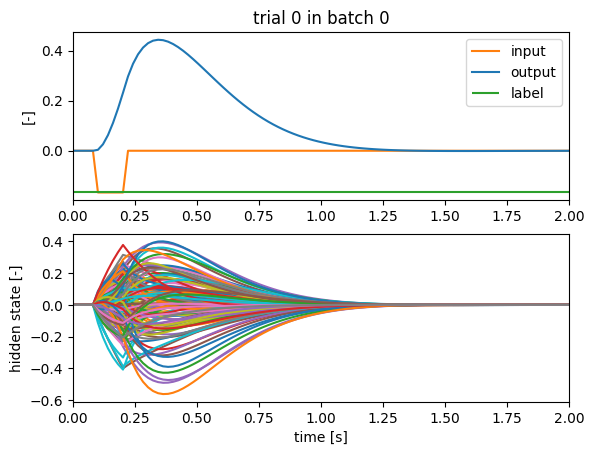

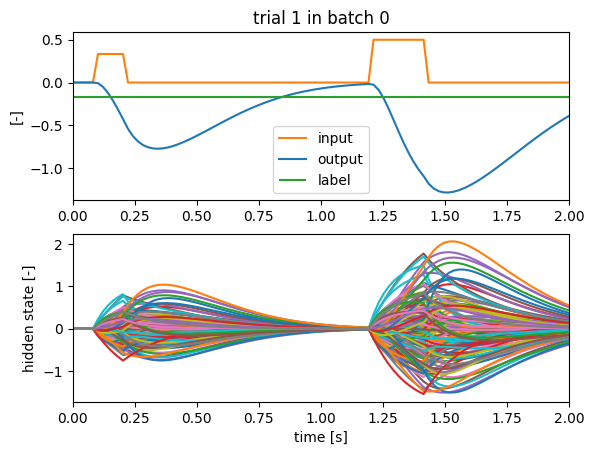

In [12]:
# test model 
test(test_dataloader, model_curriculum_learning, loss_fn, time_step_for_loss)

# visualise dynamics of trained RNN
visualise_dynamics.plot_dynamics_each_trial(
    device, model_curriculum_learning, t_max, 
    PWM_dataset_test, test_dataloader, num_trial_to_plot=2)

## 4. Analysis of selectivity and connectivity.

Compute covariance matrix in connectivity space. 

In [13]:
input_vector = model.feedforward_input.weight.cpu().detach().numpy()
readout_vector = model.readout.weight.cpu().detach().numpy().T
input_selection_vector = model.recurrent_input.right_singular_vector.cpu().detach().numpy().T
output_vector = model.recurrent_input.left_singular_vector.cpu().detach().numpy()

# set connectivity data and compute cov matrix
connectivity_data = np.hstack((input_selection_vector, output_vector, input_vector, readout_vector))
connectivity_covariance_matrix = np.cov(connectivity_data.T)
vector_names = [rf'n$^{i}$' for i in range(1, model.rank+ 1)]
vector_names.extend([rf'm$^{i}$' for i in range(1, model.rank+ 1)])
vector_names.extend(['I', 'W'])

Plot neurons in connectivity space.

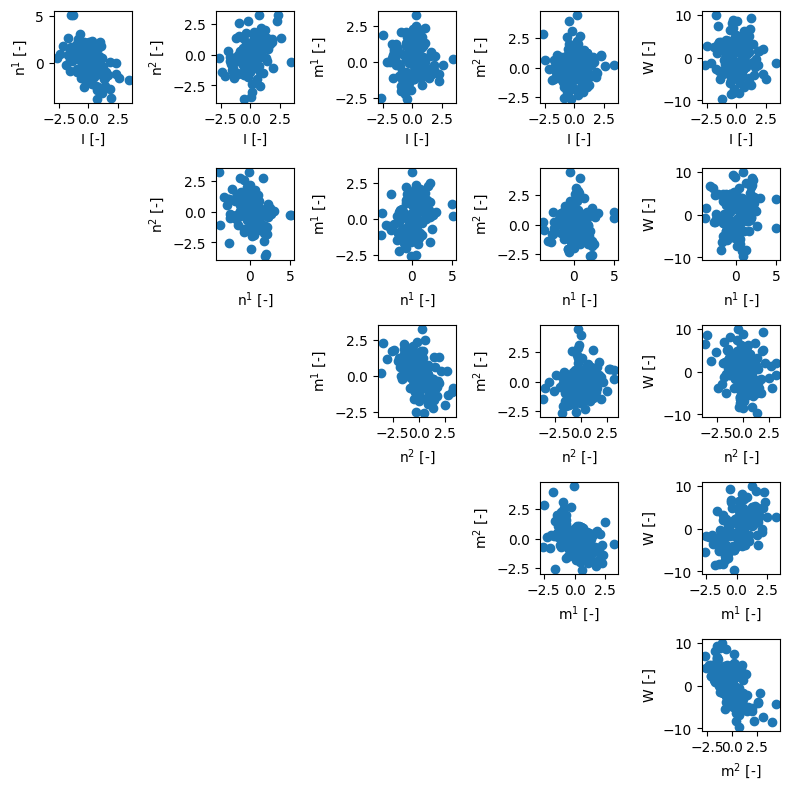

In [14]:
visualise_connectivity.plot_neurons_connectivity_space(
    connectivity_data, connectivity_covariance_matrix, model.rank)

Visualise covariance matrix.

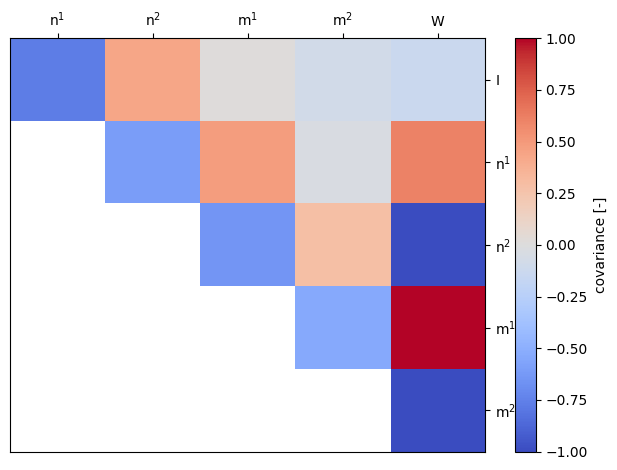

In [15]:
clim = [-1, 1]
visualise_connectivity.plot_connectivity_covariance_matrix(
    connectivity_data, connectivity_covariance_matrix, model.rank, clim)

## 5. Gaussian mixture model 

Approximate neurons in the network by a single-population GMM.

In [16]:
# fit to 4-d gaussian distribution with one population
GMM = GaussianMixture(n_components = 1, random_state=0)
GMM.fit(connectivity_data)

for i in range(connectivity_data.shape[1]):
    print(vector_names[i] + rf' mean: {GMM.means_[0][i]}')
    #GMM.covariances_

# resample from the fitted distribution
resampled_connectivity_data = \
    np.random.multivariate_normal(GMM.means_[0], GMM.covariances_[0], size=hidden_size)
print(f'shape of resampled_connectivity_data: {resampled_connectivity_data.shape}')

n$^1$ mean: 0.11403604163933778
n$^2$ mean: 0.02697741582232993
m$^1$ mean: 0.12284221885784063
m$^2$ mean: -0.022387992969015613
I mean: 0.05244113608432599
W mean: 0.28874840218850295
shape of resampled_connectivity_data: (128, 6)


Visualise original neurons and re-sampled neurons.

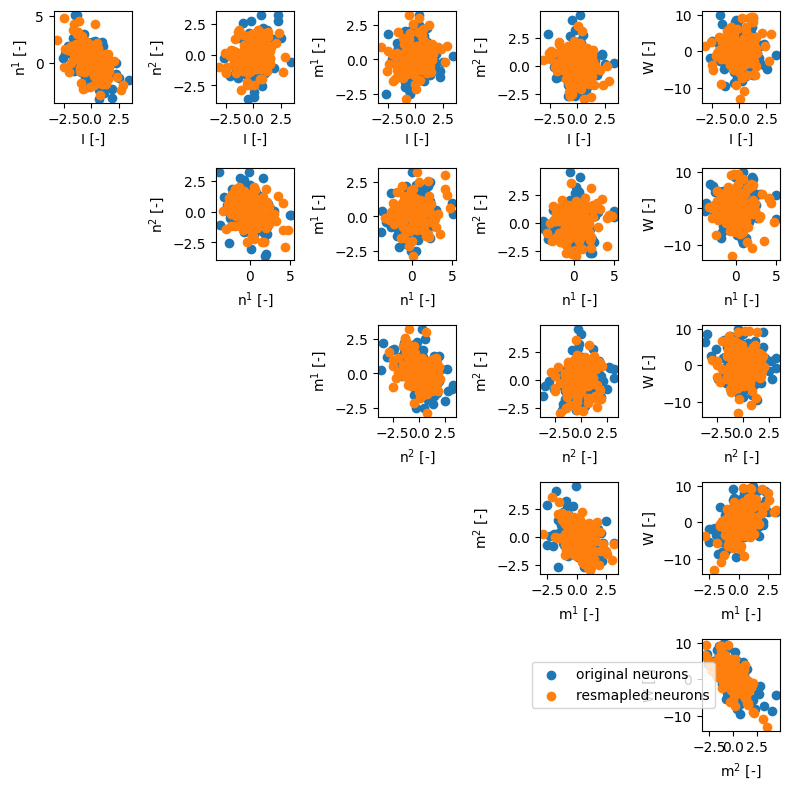

In [17]:
visualise_connectivity.plot_resampled_neurons_connectivity_space(
    resampled_connectivity_data, connectivity_data, connectivity_covariance_matrix, model.rank)

Test the network with the resampled connectivity.

Test Error: 
 Accuracy: 64.1%, Avg loss: 0.215942 



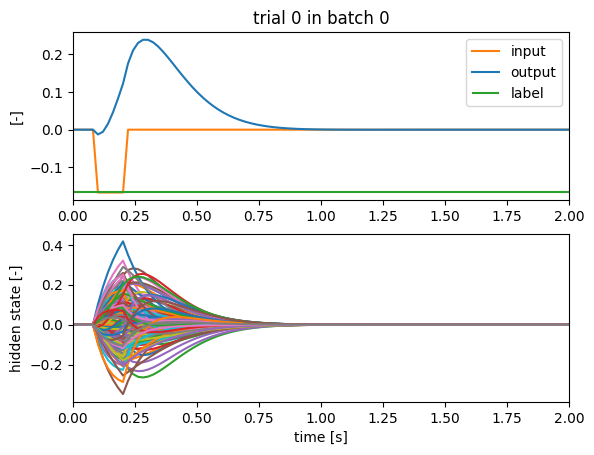

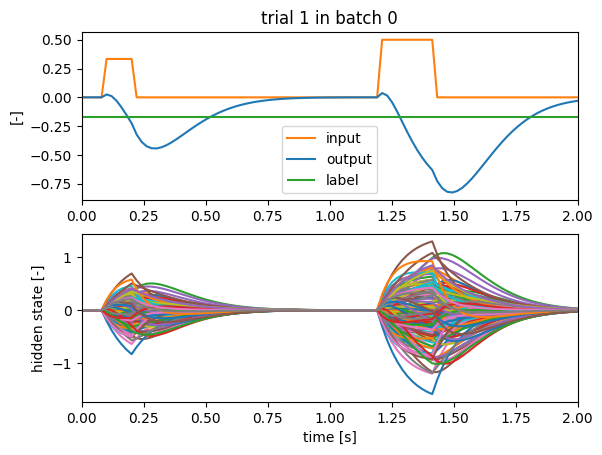

In [18]:
# Set up a network with the resampled connecitivity data.
resampled_model = \
    neural_networks.LowRankRNN(input_size, hidden_size, output_size, rank, time_step, tau).to(device)

# use resampled data for the model 
# input vector (hiddeni_size x input_size)
resampled_model.feedforward_input.weight = \
    torch.Tensor(resampled_connectivity_data[:, -2, np.newaxis])
# readout vector (output_size x hidden_size)
resampled_model.readout.weight = \
    torch.Tensor(resampled_connectivity_data[:, -1, np.newaxis].T)
# input selection vectors (rank x hidden_size)
resampled_model.recurrent_input.right_singular_vector = \
    torch.nn.Parameter(torch.Tensor(resampled_connectivity_data[:, 0:rank].T))
# output vectors (hidden_size x rank)
resampled_model.recurrent_input.left_singular_vector = \
    torch.nn.Parameter(torch.Tensor(resampled_connectivity_data[:, rank:-2]))

# test the resampled model
test(test_dataloader, resampled_model, loss_fn, time_step_for_loss)
visualise_dynamics.plot_dynamics_each_trial(
    device, resampled_model, t_max, PWM_dataset_test, test_dataloader, num_trial_to_plot=2)

## 6. Project data onto the m-I subspace.

In [19]:
sample_batched = next(iter(test_dataloader))
# run feedforward simulation and obtain the history of hidden state
hidden_state_history = np.empty((PWM_dataset_test.num_sample_points, batch_size, hidden_size))
for i_time in range(PWM_dataset_test.num_sample_points):
      if i_time == 0:
            hidden_state = model.init_hidden(batch_size)
      input_data = sample_batched['stimulus'][:, i_time].unsqueeze(dim=1)
      with torch.no_grad():
            output, hidden_state = model(input_data.to(device), hidden_state.to(device))
      hidden_state_history[i_time, :, :] = hidden_state.cpu().detach().numpy()

# project data to m 
projection_ms = (hidden_state_history @ output_vector).squeeze()
# project data to I
projection_I = (hidden_state_history @ input_vector).squeeze()

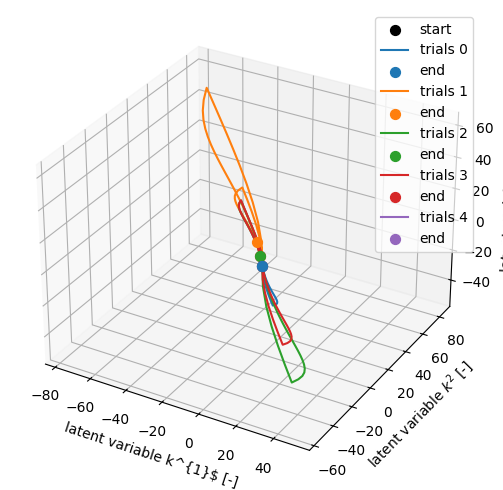

In [20]:
# plot trajectory of hidden state in the m-I plane
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(projection_ms[0, 0, 0], 
           projection_ms[0, 0, 1], 
           projection_I[0, 0], 
           s=50, color='k', label='start', zorder=10)

for i_trial in range(num_trial_to_plot):
    ax.plot(projection_ms[:, i_trial, 0],
            projection_ms[:, i_trial, 1], 
             projection_I[:, i_trial], 
             color=list_colors[i_trial],
             label=f'trials {i_trial}')
    
    ax.scatter(projection_ms[-1, i_trial, 0],
               projection_ms[-1, i_trial, 1],
               projection_I[-1, i_trial], 
               s=50, c=list_colors[i_trial], label='end', zorder=10)

ax.set_xlabel(r'latent variable k^{1}$ [-]')
ax.set_ylabel(r'latent variable $k^{2}$ [-]')
ax.set_zlabel('latent variable u [-]')
ax.legend()
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

/tmp/ipykernel_38726/1325078179.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i_rank].legend()


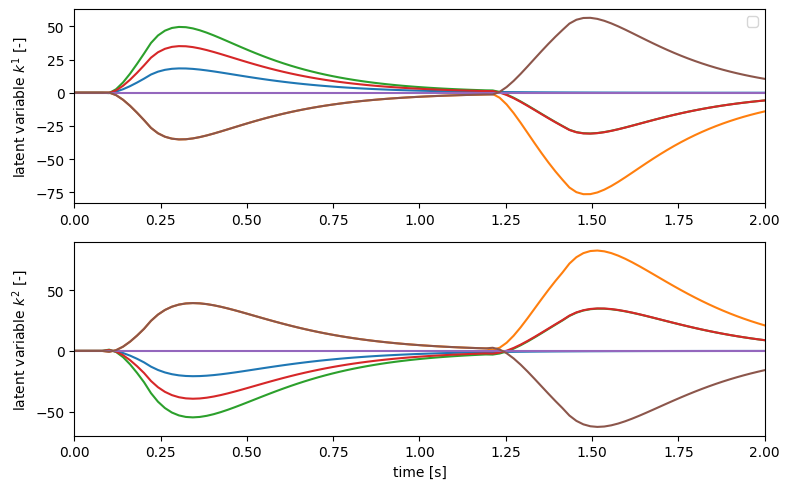

In [21]:
# plot trajectory of hidden state in the m-I plane
fig, axes = plt.subplots(rank, 1, figsize=(8, 5))

num_trial_to_plot = 6
for i_rank in range(rank):    
    axes[i_rank].plot(
        PWM_dataset_test.time,
        projection_ms[:, 0:num_trial_to_plot, i_rank])
        #projection_ms[:, num_trial_to_plot, i_rank])
        #projection_ms[:, 0:num_trial_to_plot, i_rank])
    axes[i_rank].set_ylabel(rf'latent variable $k^{i_rank+1}$ [-]')
    axes[i_rank].set_xlim([PWM_dataset_test.time[0], PWM_dataset_test.time[-1]])
    if i_rank == rank-1:
        axes[i_rank].set_xlabel('time [s]')
    elif i_rank == 0:
        axes[i_rank].legend()

#color=list_colors[0:num_trial_to_plot],
#        label=[f'trials {i_trial}' for i_trial in range(num_trial_to_plot)]
fig.tight_layout()
plt.show()